<!-- This cell is automatically updated by tools/tutorial-cell-updater.py -->
<!-- The contents are initialized from tutorials/notebook-header.md -->

[<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>](https://colab.research.google.com/github/speechbrain/speechbrain/blob/develop/docs/tutorials/nn/conformer-streaming-asr.ipynb)
to execute or view/download this notebook on
[GitHub](https://github.com/speechbrain/speechbrain/tree/develop/docs/tutorials/nn/conformer-streaming-asr.ipynb)

# Streaming Speech Recognition with Conformers

Automatic Speech Recognition (ASR) models are often only designed to transcribe an entire large chunk of audio and are unsuitable for usecases like live stream transcription, which requires low-latency, long-form transcription.

This tutorial introduces the Dynamic Chunk Training approach and architectural changes you can apply to make the Conformer model streamable. It introduces the tooling for training and inference that SpeechBrain can provide for you.
This might be a good starting point if you're interested in training and understanding your own streaming models, or even if you want to explore improved streaming architectures.

This tutorial goes very in-depth with the implementation. It may be okay to skim through depending on your goals.

The model and training procedure described here are not state-of-the-art, but it is a reasonably good and modern end-to-end approach. It has successfully been applied as the following recipes (non-exhaustive list):

- [`LibriSpeech/ASR/transducer`](https://github.com/speechbrain/speechbrain/tree/develop/recipes/LibriSpeech/ASR/transducer) ([pre-trained on HuggingFace](https://huggingface.co/speechbrain/asr-streaming-conformer-librispeech))
- [`VoxPopuli/ASR/transducer`](https://github.com/speechbrain/speechbrain/tree/develop/recipes/VoxPopuli/ASR/transducer)
- [`CommonVoice/ASR/transducer`](https://github.com/speechbrain/speechbrain/tree/develop/recipes/CommonVoice/ASR/transducer) (French, Italian)

## Recommended prerequisites

- [Speech Recognition From Scratch](https://speechbrain.readthedocs.io/en/latest/tutorials/tasks/speech-recognition-from-scratch.html)

### Installing SpeechBrain

In [1]:
%%capture
# Installing SpeechBrain via pip
BRANCH = 'develop'
!python -m pip install git+https://github.com/speechbrain/speechbrain.git@$BRANCH

In [ ]:
%%capture
%pip install matplotlib

## What a streaming model needs to achieve

We need a fine-grained way to restrict and remember context so that the model attends only on **recent context** and **not future frames**. That strategy must somehow be **consistent between training and inference**.

Traditional models might have the luxury of reusing the same forward code path for both training and inference. Training and inference when streaming kind of have opposite performance characteristics, and this results in special casing in some layers.

- For inference, we generally need to process outputs chunk-by-chunk as they come in, and this usually implies caching some past hidden state at different layers.
- For training, we prefer to pass in a large batch of whole utterances, once, to maximize GPU occupancy and lower Python and CUDA kernel launching overhead. Thus, we would prefer to enforce these restrictions by masking.

### Summary of the tutorial

This tutorial attempts to split up the theory and practice in separate sections. This is a summary of each of the sections:

1. Introduce architectural changes to the Conformer model. We will discuss:
    - How we solve future dependencies of the self-attention mechanism with chunked attention masking.
    - How we solve future dependencies of the convolution module with Dynamic Chunk Convolutions.
    - Why we can avoid changing the feature extractor and positional embeddings for training.
2. Explain the Dynamic Chunk Training strategy for training. We will discuss:
    - How to train the model to support various chunk sizes and left context sizes to be selected at runtime.
    - The consequences of changing the chunk size and left context size.
    - The implications of different loss functions for streaming model training.
3. List the actual changes required to a train a streaming Conformer in SpeechBrain.
4. Explain how to debug neural layers to ensure correct streaming behavior.
5. Introduce all the parts involved in streaming inference. We will:
    - Introduce the wrapper to adapt a non-streaming feature extractor into a streaming one.
    - Explain the streaming context object architecture and streaming forward methods.
    - List misceallenous other changes to be done to the model.
6. Give a practical introduction to inference tools in SpeechBrain. We will:
    - Demonstrate how to make a trained streaming-capable model ready for streaming inference.
    - Provide complete examples of the `StreamingASR` inference interface for stream or file processing.

## Architectural Changes to the Conformer

<img src="../assets/conformer-simple.png" alt="Simplified Conformer Diagram" width="450"/>

The above is a (very) simplified diagram of the vanilla Conformer architecture as used in one of our models, to read from top to bottom.  
Colored bricks are the ones that require us to be careful when streaming, as they propagate information across time steps.

### Chunked Attention

#### What is Causal Attention?

If you are familiar with Transformer architectures, you may be familiar with causal attention. In a nutshell, causal attention makes it so that the output frame at timestep $t$ cannot attend to an input from a "future" timestep ($t+1$, $t+2$, etc.).

This directly implies that if you want to predict the output of the model at timestep $t$, you only need "current" and "past" inputs ($t$, $t-1$, $t-2$, etc.). This is important to us, because we _don't_ know the future frames!

Causal attention is very simple to apply (naively), and actually fits the bill for streaming ASR... But we won't use it here.

#### What is Chunked Attention, and why do we prefer it?

Causal attention is simple to implement, but for streaming ASR, it is found to disproportionately degrade the Word Error Rate.
For this reason, chunked attention is often chosen in streaming attentive models instead.

Conceptually, chunked attention introduces the idea of _chunks_ that group a given amount of frames (`chunk_size`). For example, if you were to have a chunk size of 4, then you would look at your input like this:

<img src="../assets/attention-chunking.png" alt="Chunking of inputs" width="800"/>

**Frames within a chunk can attend to each other**. This retains more of the expressive power of attention compared to causal attention.  
Chunks can also attend to past chunks, but we **limit how far into the past** to reduce the computational and memory cost at inference time (`left_context_chunks`).

At training time, we enforce this using an **attention mask**. An attention mask answers the question: Can the `j`-th output frame attend to the `i`-th input frame?  
As such, it is defined as a boolean tensor defined with a shape of `(t, t)`. Here follows an example of one (although the actual mask is a transposition of this):

<img src="../assets/attn-restrict.png" alt="Chunked Attention example diagram" width="800"/>

In fact, we can rather easily reproduce this exact mask. Note that we are transposing the mask for display, and that here, a `True` (red) means **masking**, and `False` (blue) means **not masking**:

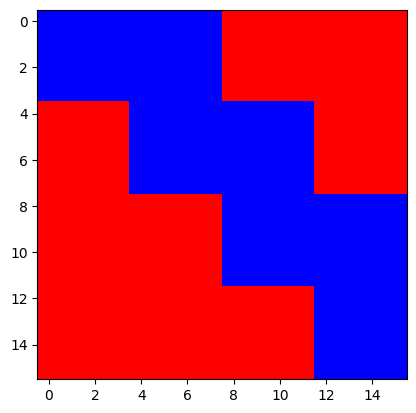

In [45]:
from speechbrain.lobes.models.transformer.TransformerASR import make_transformer_src_mask
from speechbrain.utils.dynamic_chunk_training import DynChunkTrainConfig
from matplotlib import pyplot as plt
import torch

# dummy batch size, 16 sequence length, 128 sized embedding
chunk_streaming_mask = make_transformer_src_mask(torch.empty(1, 16, 128), dynchunktrain_config=DynChunkTrainConfig(4, 1))
plt.imshow(chunk_streaming_mask.T, cmap="bwr")
plt.show()

#### Chunked Attention during inference

When designing streaming models, we need to be very careful about how dependencies between output frames and input frames propagate across layers.

For instance, thinking back about _causal_ attention, you might wonder if we could have regained some accuracy by allowing the output frame at timestep $t$ to attend to an input frame at timestep $t+1$, i.e. giving it some "right"/future context at every layer.  
_Yes,_ we _could_, and it does help somewhat, but consider the implications when stacking layers! For instance, consider two layers of attention, where $a$ is the input, $b$ is the output of the first layer, and $c$ is the output of the second layer: $c_t$ will attend to $b_{t+1}$ (among others), which itself will attend to $a_{t+2}$. This gets worse in practice, when we might have something like 12 or 17 layers.  
This is cumbersome, and will likely have a negative effect on latency (we'd need to buffer a bunch of "future" frames) and memory/computational cost.

On the other hand, chunk attention plays very nicely with this. **Let's ignore left context first.** The following example focuses on the 4th chunk of the input, and on which frames effectively depend on/attend to which:

<img src="../assets/attention-chunking-no-lc.png" alt="Chunked Attention (example with no left context)" width="800"/>

Ignoring left context, frames within one chunk may attend to each other. If you stack attention layers, the **boundaries of chunks remain the same across layers**.

Now, let's add left context. In the following example, we will assume a left context size of 1 chunk. For clarity, we omit the connections for <span style="color: red">12,13,14</span> but they attend to the _same frames_ as <span style="color: red">15</span>.

<img src="../assets/attention-chunking-dep.png" alt="Chunked Attention (example with left context)" width="800"/>

> _Wait, shouldn't this mean that the outputs <span style="color: red">12,13,14,15</span> of `Layer #2` need us to remember the embeddings for inputs <span style="color: green">4,5,6,7</span>?_

No! The <span style="color: red">12,13,14,15</span> chunk at `Layer #2` does indeed depend on <span style="color: orange">8,9,10,11</span> of `Layer #1`, which itself depends on <span style="color: green">4,5,6,7</span> of `Inputs`.  
However, the hidden state of <span style="color: orange">8,9,10,11</span> at `Layer #1` isn't at all affected by our red chunk! Thus, when inferring, we can cache however many left context chunks we want to use, and the amount of things we have to cache/recompute doesn't explode with the number of layers we have.

[`speechbrain.lobes.models.transformer.TransformerASR.make_transformer_src_mask`](https://speechbrain.readthedocs.io/en/latest/_modules/speechbrain/lobes/models/transformer/TransformerASR.html#make_transformer_src_mask) is the function that generates these masks.

> _How does that work out at inference time?_

Left context is defined so that a given chunk $i$ can attend to `left_context_chunks` chunks, i.e. that all output frames within chunk $i$ can attend to all frames within the past `left_context_chunks` chunks.  
Ultimately, this design allows us to define the math for processing attention for a given input chunk at inference time to something that looks like this:

```python
attention_module(concat(cached_left_chunks, input_chunk))
```

Ignoring KV caching, here, `cached_left_chunks` ends up being, _for each layer_, a tensor of size `(batch_size, left_context_chunks * chunk_size, emb_dim)`. This is fairly reasonable, and it is the only thing we have to save at inference time for the attention part.

### Dynamic Chunk Convolutions

#### Vanilla Convolutions

<img src="../assets/dcc-regular.png" alt="Vanilla Convolutions" width="800"/>

<sup>Credit: <a href="https://www.amazon.science/publications/dynamic-chunk-convolution-for-unified-streaming-and-non-streaming-conformer-asr">Xilai Li et al, 2023</a> (Dynamic Chunk Convolution paper)<br>
Example with a convolution $k=5$, meaning that "half a window", $\frac{k-1}{2}$, is $2$</sup>

Vanilla convolutions operate over windows, which, for the convolution output at timestep $t$, spans indices from $t-\frac{k-1}{2}$ to $t+\frac{k-1}{2}$, where $k$ is the kernel size. Thus, the output at timestep $t$ will depend on future frames, which we want to avoid.  
We could pretend to ignore the problem by training normally, and at inference, right-pad frames we don't know as zeros (see figure). This would, however, be a major mismatch between training and inference, and would harm accuracy significantly.

#### Causal Convolutions

<img src="../assets/dcc-causal.png" alt="Causal Convolutions" width="800"/>

There _is_ a direct solution: Causal convolutions. They merely shift the window for output $t$ to instead cover indices from $t-(k-1)$ to $t$.  
The math for that is very simple: You just need to pad the input to the left by $\frac{k-1}{2}$ frames, pass it to the convolution, and truncate these $\frac{k-1}{2}$ output frames on the left.

#### Dynamic Chunk Convolution

<img src="../assets/dcc-dcc.png" alt="Dynamic Chunk Convolutions" width="800"/>

Unfortunately, causal convolutions result in worse accuracy. To remedy this, <a href="https://www.amazon.science/publications/dynamic-chunk-convolution-for-unified-streaming-and-non-streaming-conformer-asr">Xilai Li et al, 2023</a> introduces the idea of _Dynamic Chunk Convolutions_ for streaming chunked ASR.

With this, we reuse the same chunk boundaries we used for chunked attention.  
In the above figure, consider frame $T_{15}$: It looks a lot like a vanilla convolution, except that **any input frame that belongs to a future _chunk_ is masked off**. This solves our problem of depending on future frames.  

Note how the leftmost output of the example chunk, $T_0$, depends on $\frac{k-1}{2}$ past frames: At inference time, we will need to cache at this, at each layer. This is reasonably lightweight, though.

The implementation for this at training time is actually far from obvious, because PyTorch convolution operators cannot merely take in a mask similar to the self-attention mask we used. If you are feeling adventurous, you can read the source code for [`speechbrain.lobes.models.transformer.Conformer.ConvolutionModule`](https://speechbrain.readthedocs.io/en/latest/_modules/speechbrain/lobes/models/transformer/Conformer.html#ConvolutionModule), which is a pile of (commented and illustrated) tensor reshaping magic.

### What we _aren't_ changing

Some parts of the architecture don't really matter and don't require any special care for streaming, because they don't propagate information between frames (i.e. they are only pointwise).  
Some, on the other hand, need some explanation as to why they do or don't matter.

#### Feature Extraction

As implemented in SpeechBrain, the feature extractor for the Conformer is _not_ causal. This would normally be a concern for streaming, but we are leaving it unchanged in training. What gives?

It turns out that the feature extraction **does not really need much right context** (i.e. to see many future frames). We _can_ afford to introduce the idea of some right context for this, as it represents speech in the order of milliseconds anyway. This kind of simplifies the whole ordeal, and gives more flexibility for poking around the feature extractor.

SpeechBrain provides a wrapper, [`speechbrain.lobes.features.StreamingFeatureWrapper`](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.lobes.features.html#speechbrain.lobes.features.StreamingFeatureWrapper), which abstracts this for you almost entirely, by automatically padding and caching context. It still needs to be told the characteristics of the feature extractor, which we will expand on later on.

Normalization is another part of the feature extractor that was not edited. This actually creates a discrepancy between training and test, but we found it to be minimal, even between full audio normalization and per-chunk normalization. It is thus pretty much ignored, although you could give it more care.

#### Positional embeddings

We won't go into very detailed explanations of positional embeddings here, even though they play a major role in model accuracy in ASR. What is important to know is that they enrich the attention mechanism with position information. Otherwise, the model would lack information of where tokens are relative to each other.

Luckily, we are using a model that we define in SpeechBrain to use relative positional sinusoidal encodings ([`speechbrain.nnet.attention.RelPosEncXL`](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.nnet.attention.html#speechbrain.nnet.attention.RelPosEncXL)). We will underline why this is useful below.

In self-attention, any _query_ can attend to any _key_ (as long as that _query_/_key_ pair is not masked, as we do need for chunked attention).  

- Without a positional embedding, the attention mechanism would ignore where the _query_ and _key_ actually are in the sentence.  
- With a rather naive positional embedding, we would care about the position of the _key_ relative to the start of the sentence. This works, but is problematic for streaming ASR in a few ways. Most notably, the distances would get quite long.
- With our **relative positional embedding**, we look at the **difference** of position between the _query_ and the _key_.

Since we have chunked attention that restricts how much into the past and future a _query_ can attend, the distance we encode is never larger than the window of frames we attend to.  
In other words, if we attend to chunks of 16 tokens with 48 tokens of left context, we will at most represent a distance from the rightmost token to the leftmost token, i.e. $63$.  
The distance of $63$ would have its own fixed positional encoding vector, which is taken into account for the score calculation in self-attention for that specific _query_/_key_ pair.

Furthermore, no matter if we are $0$ second or $30$ minutes into the stream, these distances remain the same, as they are relative positions.

The following example demonstrates a relative positional encoding on a sequence of 16 timesteps and an embedding size of 64:

(batch, seq_len*2-1, emb_size): (1, 31, 64)


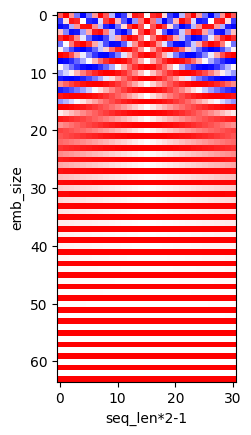

In [165]:
from speechbrain.nnet.attention import RelPosEncXL
from matplotlib import pyplot as plt

test_pos_encoder = RelPosEncXL(64)
test_pos = test_pos_encoder.make_pe(seq_len=16)
print(f"(batch, seq_len*2-1, emb_size): {tuple(test_pos.shape)}")
plt.imshow(test_pos.squeeze(0).T, cmap="bwr")
plt.xlabel("seq_len*2-1")
plt.ylabel("emb_size")
plt.show()

In the above figure, the center column corresponds to the position embedding vector for a positional difference of zero, i.e., the key being attended to is the same input as the query.

The horizontal distance from the center represents the distance between a given query and key pair inside the self-attention.  
One column to the right of the center would represent a distance of $1$, etc.

This doesn't depend on the distance of either the key or the query from the start of the sequence.  
At inference time, we only need to make the `seq_len` above ever as large as the attention window is (left context + active chunk).

Note that this embedding is further enriched by being passed into a learnable linear layer first.

## Training strategies and Dynamic Chunk Training

### What metrics does the chunk size and left context size impact?

Usually, when streaming, we try to split the input stream in a way that matches the chunk size, and we process chunks one by one as they arrive.

**Smaller chunks degrade accuracy** more, but result in **lower latency**.  
It's a tradeoff depending on the final usecase, and it's worth benchmarking different chunk sizes on whatever test dataset is representative of the final application.

Looking at the data from [`speechbrain/asr-streaming-conformer-librispeech`](https://huggingface.co/speechbrain/asr-streaming-conformer-librispeech), for a left chunk count of 4, and this _specific model and dataset_, we get a curve like this (mind the scale):

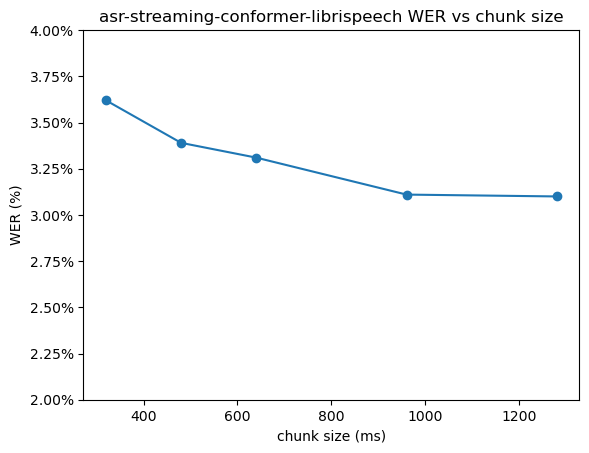

In [3]:
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

xs = [1280,  960,  640,  480,  320]
ys = [3.10, 3.11, 3.31, 3.39, 3.62]
plt.scatter(xs, ys)
plt.plot(xs, ys)
plt.ylim(2, 4)
plt.title("asr-streaming-conformer-librispeech WER vs chunk size")
plt.xlabel("chunk size (ms)")
plt.ylabel("WER (%)")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

Left context size is purely a tradeoff between accuracy and computational/memory cost. Here too, it is worth evaluating the model with different sizes depending on the desired tradeoff.

### How to pick the chunk size?

Curiously, it doesn't have to be static! The following strategy works surprisingly well:

- For 40% of the batches (at random), we train normally without any chunking strategy.
- For the other 60%, we do the following:
  - For each batch, we sample a random chunk size between some reasonable values (e.g. uniform sampling between 8 and 32 vanilla conformer frames)
  - For 75% of these chunks, we restrict the left context similarly (e.g. 2-32 chunks). For the other 25%, we don't.

This strategy is abstracted in SpeechBrain by [`speechbrain.utils.dynamic_chunk_training.DynChunkTrainConfigRandomSampler`](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.utils.dynamic_chunk_training.html#speechbrain.utils.dynamic_chunk_training.DynChunkTrainConfigRandomSampler).

The consequence of this is very interesting: The trained model can still infer in a **traditional, non-streaming fashion**, but it can also infer in a streaming fashion with a **chunk size chosen at run-time**! Surprisingly, we found the error rate degradation vs. an unmodified model in the former case is sometimes minimal, but the impact might likely be more significant for other hyperparameters and datasets.

Let's write an example:

In [36]:
from speechbrain.core import Stage
from speechbrain.utils.dynamic_chunk_training import DynChunkTrainConfig
from speechbrain.utils.dynamic_chunk_training import DynChunkTrainConfigRandomSampler

sampler = DynChunkTrainConfigRandomSampler(
    chunkwise_prob=0.6,
    chunk_size_min=8,
    chunk_size_max=32,
    limited_left_context_prob=0.8,
    left_context_chunks_min=2,
    left_context_chunks_max=16,
    test_config=DynChunkTrainConfig(32, 16),
    valid_config=None
)

for i in range(10):
    print(f"Draw #{i:<2}     -> {sampler(Stage.TRAIN)}")

print()
print(f"Test config  -> {sampler(Stage.TEST)}")
print(f"Valid config -> {sampler(Stage.VALID)}")

Draw #0      -> None
Draw #1      -> DynChunkTrainConfig(chunk_size=5, left_context_size=None)
Draw #2      -> DynChunkTrainConfig(chunk_size=23, left_context_size=None)
Draw #3      -> None
Draw #4      -> DynChunkTrainConfig(chunk_size=12, left_context_size=14)
Draw #5      -> DynChunkTrainConfig(chunk_size=19, left_context_size=14)
Draw #6      -> DynChunkTrainConfig(chunk_size=24, left_context_size=None)
Draw #7      -> DynChunkTrainConfig(chunk_size=16, left_context_size=None)
Draw #8      -> DynChunkTrainConfig(chunk_size=8, left_context_size=6)
Draw #9      -> DynChunkTrainConfig(chunk_size=12, left_context_size=None)

Test config  -> DynChunkTrainConfig(chunk_size=32, left_context_size=16)
Valid config -> None


### Loss function(s)

The easiest way to train a streaming Conformer model is currently using the RNN-T loss (and optionally CTC as an auxiliary loss to improve training). For a refresher, see [Speech Recognition From Scratch](https://speechbrain.readthedocs.io/en/latest/tutorials/tasks/speech-recognition-from-scratch.html) and its linked resources.

It may be possible to also add encoder-decoder cross-entropy as either an auxiliary loss (to improve model accuracy even if using the RNN-T path for inference), or used for streaming, but this was not tested and is currently unsupported.  
To implement this, you may want to explore the litterature and the approach taken by competitive models.

## Training: Piecing it all together with SpeechBrain

This was a whole lot of theory, but how do we make use of what SpeechBrain has implemented?  
The following describes what code should be used, and what streaming-specific code there is in a typical streaming Conformer-Transducer recipe.
You would preferably adapt a known-good recipe (such as [`LibriSpeech/ASR/transducer`](https://github.com/speechbrain/speechbrain/tree/develop/recipes/LibriSpeech/ASR/transducer).

If you are trying to adapt a different model, this might help you, but you may need to do more research and work.

### Automatic masking by passing a Dynamic Chunk Training configuration

The [`speechbrain.utils.dynamic_chunk_training.DynChunkTrainConfig`](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.utils.dynamic_chunk_training.html#speechbrain.utils.dynamic_chunk_training.DynChunkTrainConfig) class was added, whose purpose is to describe a streaming configuration for _one_ batch.
In order to implement a complete Dynamic Chunk Training strategy, your training script may sample a random configuration for each batch from a [`DynChunkTrainConfigRandomSampler`](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.utils.dynamic_chunk_training.html#speechbrain.utils.dynamic_chunk_training.DynChunkTrainConfigRandomSampler). (You are free to implement your own strategy, if you prefer.)

Various functions were enhanced, such as [`TransformerASR.encode`](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.lobes.models.transformer.TransformerASR.html#speechbrain.lobes.models.transformer.TransformerASR.TransformerASR.encode), to take in a `dynchunktrain_config` as an optional argument.  
This parameter allows you to pass a dynamic chunk **training** configuration for this specific batch. When `None`/not passed, nothing is changed.

The argument is passed down to each layer, as required. With a stock Conformer configuration, passing this object is all you need to make the encoder module streaming-capable. This makes it rather easy to navigate through the code.

### Changes to the `.yaml`

These following snippets are relevant:

```yaml
streaming: True  # controls all Dynamic Chunk Training & chunk size & left context mechanisms
```

As described just before, the config sampler is useful to describe the training strategy in hyperparameters:

```yaml
# Configuration for Dynamic Chunk Training.
# In this model, a chunk is roughly equivalent to 40ms of audio.
dynchunktrain_config_sampler: !new:speechbrain.utils.dynamic_chunk_training.DynChunkTrainConfigRandomSampler # yamllint disable-line rule:line-length
   chunkwise_prob: 0.6 # Probability during a batch to limit attention and sample a random chunk size in the following range
   chunk_size_min: 8 # Minimum chunk size (if in a DynChunkTrain batch)
   chunk_size_max: 32 # Maximum chunk size (if in a DynChunkTrain batch)
   limited_left_context_prob: 0.75 # If in a DynChunkTrain batch, the probability during a batch to restrict left context to a random number of chunks
   left_context_chunks_min: 2 # Minimum left context size (in # of chunks)
   left_context_chunks_max: 32 # Maximum left context size (in # of chunks)
   # If you specify a valid/test config, you can optionally have evaluation be
   # done with a specific DynChunkTrain configuration.
   # valid_config: !new:speechbrain.utils.dynamic_chunk_training.DynChunkTrainConfig
   #    chunk_size: 24
   #    left_context_size: 16
   # test_config: ...
```

Make sure that you are using a supported architecture (such as Conformer, with `TransformerASR`'s `causal` parameter set to `False`).

Currently, only greedy search is supported in a streaming context. You probably want to make it so that your `test` set is evaluated with greedy search.

Additionally, you can specify a `valid_config` or `test_config` to the sampler (see comments) in order to emulate streaming when evaluating your model on either of the sets.

### Changes to the `train.py`

In the `compute_forward`, you should sample a random config (so that it is different for each batch):

```python
if self.hparams.streaming:
    dynchunktrain_config = self.hparams.dynchunktrain_config_sampler(stage)
else:
    dynchunktrain_config = None
```

Then, assuming the encoder is available as an `enc` hyperparameter, edit its call to forward the `dynchunktrain_config`:

```python
x = self.modules.enc(
    src,
    #...
    dynchunktrain_config=dynchunktrain_config,
)
```

For training, that should be it!

## Debugging Streaming architectures

[`speechbrain.utils.streaming`](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.utils.streaming.html#module-speechbrain.utils.streaming) provides some useful functionality, including debug features we will demonstrate.

### Detecting future dependencies in NN layers

As you may have noticed, retrofitting streaming support to an existing architecture is not trivial, and it is easy to miss accidental dependencies to the future.  
[`speechbrain.utils.streaming.infer_dependency_matrix`](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.utils.streaming.html#speechbrain.utils.streaming.infer_dependency_matrix) can compute a matrix of dependencies between output frames and input frames for you.  
It does so by repeatedly calling your module and figuring out which outputs were affected by the randomization of which input.  
It can also detect if your model is not deterministic enough, i.e. that two consecutive calls resulted in different data.  

The output can then be visualized using [`speechbrain.utils.streaming.plot_dependency_matrix`](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.utils.streaming.html#speechbrain.utils.streaming.plot_dependency_matrix).  
A red cell means that a given output can have its value affected by a given input. As a result, these plots might look very familiar if you have seen the previous figures.  
Note that due to the implementation, on larger plots and on some models, you might see some random holes. These can be false negatives. Don't rely on `infer_dependency_matrix` to give perfect outputs!

Here are examples of dependency plots with actual Conformer layers:

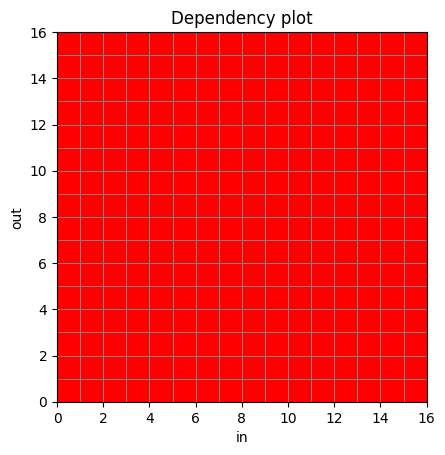

In [119]:
from speechbrain.lobes.models.transformer.TransformerASR import TransformerASR
from speechbrain.utils.streaming import infer_dependency_matrix, plot_dependency_matrix
from matplotlib import pyplot as plt

noncausal_model = TransformerASR(
    tgt_vocab=64, input_size=64, d_model=64, nhead=1, d_ffn=64, 
    encoder_module="conformer", normalize_before=True,
    attention_type="RelPosMHAXL",
    num_encoder_layers=4, num_decoder_layers=0,
    causal=False
)
noncausal_model.eval()
noncausal_deps = infer_dependency_matrix(noncausal_model.encode, seq_shape=[1, 16, 64])
plot_dependency_matrix(noncausal_deps)
plt.show()

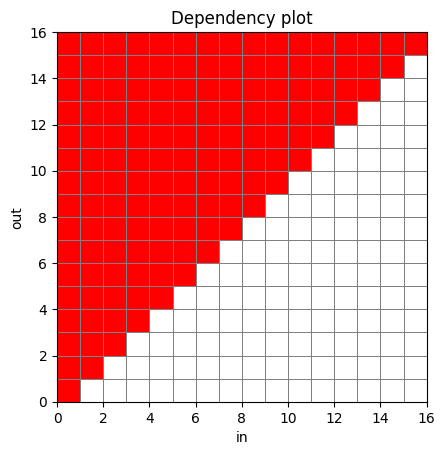

In [120]:
causal_model = TransformerASR(
    tgt_vocab=64, input_size=64, d_model=64, nhead=1, d_ffn=64, 
    encoder_module="conformer", normalize_before=True,
    attention_type="RelPosMHAXL",
    num_encoder_layers=4, num_decoder_layers=0,
    causal=True
)
causal_model.eval()
causal_deps = infer_dependency_matrix(causal_model.encode, seq_shape=[1, 16, 64])
plot_dependency_matrix(causal_deps)
plt.show()

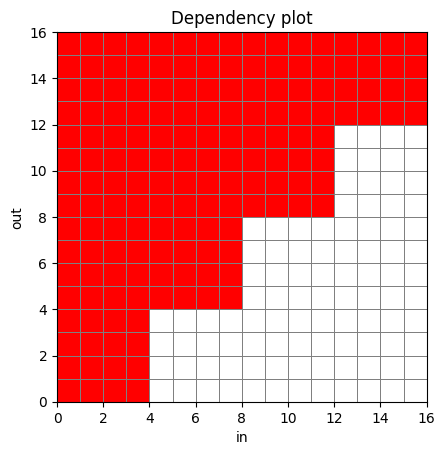

In [121]:
from speechbrain.utils.dynamic_chunk_training import DynChunkTrainConfig

chunked_model = TransformerASR(
    tgt_vocab=64, input_size=64, d_model=64, nhead=1, d_ffn=64, 
    encoder_module="conformer", normalize_before=True,
    attention_type="RelPosMHAXL",
    num_encoder_layers=4, num_decoder_layers=0,
    causal=False
)
chunked_model.eval()
chunked_conf = DynChunkTrainConfig(chunk_size=4, left_context_size=1)
chunked_deps = infer_dependency_matrix(lambda x: chunked_model.encode(x, dynchunktrain_config = chunked_conf), seq_shape=[1, 16, 64])
plot_dependency_matrix(chunked_deps)
plt.show()

As a reminder, it is normal for the _above_ to have e.g. the output at timestep $t=15$ depend on $t=0$.  
In none of the layers does $t=15$ _directly_ attend to $t=0$. Read the chunked attention section for more details.

If we want to see pure chunking without any left context, we can reduce the kernel size of the convolution module, disable left context entirely, and observe the following:

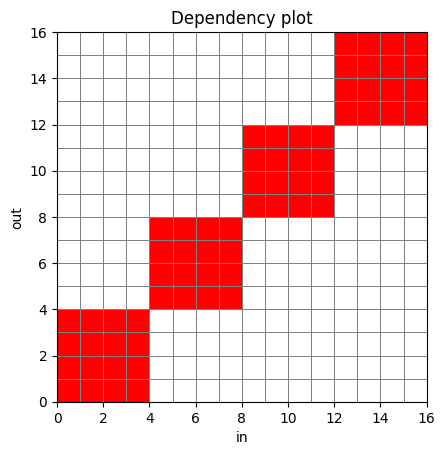

In [124]:
from speechbrain.utils.dynamic_chunk_training import DynChunkTrainConfig

chunked_model_nopast = TransformerASR(
    tgt_vocab=64, input_size=64, d_model=64, nhead=1, d_ffn=64, 
    encoder_module="conformer", normalize_before=True,
    attention_type="RelPosMHAXL",
    num_encoder_layers=4, num_decoder_layers=0,
    kernel_size=1,
    causal=False
)
chunked_model_nopast.eval()
chunked_conf = DynChunkTrainConfig(chunk_size=4, left_context_size=0)
chunked_deps = infer_dependency_matrix(lambda x: chunked_model_nopast.encode(x, dynchunktrain_config = chunked_conf), seq_shape=[1, 16, 64])
plot_dependency_matrix(chunked_deps)
plt.show()

## Inference: The gory details

### Wrapping the feature extractor for inference

We briefly touched on wrapping the feature extractor for streaming inference. The Conformer feature extractor we use here has essentially three layers:

1. Filterbank extraction, derived directly from a fourier transform of the signal (see the [Fourier Transforms and Spectrograms](https://speechbrain.readthedocs.io/en/latest/tutorials/preprocessing/fourier-transform-and-spectrograms.html) and [Speech Features](https://speechbrain.readthedocs.io/en/latest/tutorials/preprocessing/speech-features.html) tutorials)
2. Normalization (which we choose to apply per-chunk at streaming, as described earlier -- it doesn't really affect things)
3. Two downsampling CNNs, each being a convolution with a stride of 2, effectively dividing the time dimension by 4.

We have two problems here:

- We define chunk size at transformer level (after feature extraction). Thus, we need to know exactly how many frames we should give the extractor to get the expected shape. For this, we need to know exactly how the feature extractor transforms the shape.
- We need to handle left/past and right/future context correctly for the feature extractor to behave basically exactly the same as it did during training.

Let's try to visualize the problem. We will define a fairly standard Conformer feature extractor for a 16kHz input waveform. Note that the stride on the x axis is 16, meaning 1ms. Thus, the x axis counts can be seen as milliseconds (and there is in reality 16x more input samples than shown in the plot).

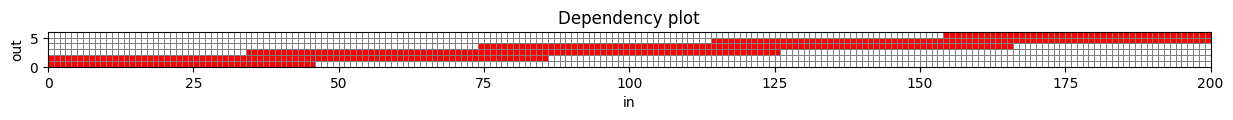

In [78]:
from speechbrain.utils.streaming import infer_dependency_matrix, plot_dependency_matrix
from hyperpyyaml import load_hyperpyyaml
from matplotlib import pyplot as plt

feat_extractor_hparams = load_hyperpyyaml("""
compute_features: !new:speechbrain.lobes.features.Fbank
   sample_rate: 16000
   n_fft: 512
   n_mels: 80
   win_length: 32

cnn: !new:speechbrain.lobes.models.convolution.ConvolutionFrontEnd
   input_shape: (8, 10, 80)
   num_blocks: 2
   num_layers_per_block: 1
   out_channels: (64, 32)
   kernel_sizes: (3, 3)
   strides: (2, 2)
   residuals: (False, False)

feat_extractor: !new:speechbrain.nnet.containers.LengthsCapableSequential
    - !ref <compute_features>
    - !ref <cnn>

properties: !apply:speechbrain.utils.filter_analysis.stack_filter_properties
    - [!ref <compute_features>, !ref <cnn>]
""")
feat_extractor_hparams["cnn"].eval()

feat_extractor_deps = infer_dependency_matrix(
    # we need some shape magic here to adapt the input and output shape to what infer_dependency_matrix expects
    # for the input, squeeze the feature dimension
    # for the output, flatten the channels dim as the output is of shape [batch, t, c0, c1]
    lambda x: feat_extractor_hparams["feat_extractor"](x.squeeze(-1)).flatten(2),
    # 100ms audio (@16kHz)
    seq_shape=[1, 3200, 1],
    # 1ms stride (@16kHz)
    in_stride=16
)
feat_extractor_fig = plot_dependency_matrix(feat_extractor_deps)
feat_extractor_fig.set_size_inches(15, 10)
plt.show()

#### Using and defining filter properties

To solve this:

1. We consider filterbank extraction and the CNN as filters (in the signal processing sense) with a specific stride, kernel size (plus dilation and causality which we don't use here). In SpeechBrain, this data is represented as [`FilterProperties`](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.utils.filter_analysis.html#speechbrain.utils.filter_analysis.FilterProperties).  
2. We provide [`get_filter_properties` methods](https://speechbrain.readthedocs.io/en/latest/search.html?q=get_filter_properties&check_keywords=yes&area=default) for some modules (note that not many have it yet).  
3. [`stack_filter_properties`](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.utils.filter_analysis.html#speechbrain.utils.filter_analysis.stack_filter_properties) is then used to "stack" these filters and get the resulting properties for the entire feature extractor.

Let's demonstrate these.

In [63]:
from speechbrain.utils.filter_analysis import stack_filter_properties

print(f"""Filter properties of the fbank module (including the STFT):
    fbank -> {feat_extractor_hparams['compute_features'].get_filter_properties()}

Filter properties of the downsampling CNN:
    ... of each layer:
    cnn[0] -> {feat_extractor_hparams['cnn']['convblock_0'].get_filter_properties()}
    cnn[1] -> {feat_extractor_hparams['cnn']['convblock_1'].get_filter_properties()}

    ... with both layers stacked:
    cnn    -> {feat_extractor_hparams['cnn'].get_filter_properties()}

Properties of the whole extraction module (fbank+CNN stacked):
    both   -> {feat_extractor_hparams['properties']}""")

Filter properties of the fbank module (including the STFT):
    fbank -> FilterProperties(window_size=512, stride=160, dilation=1, causal=False)

Filter properties of the downsampling CNN:
    ... of each layer:
    cnn[0] -> FilterProperties(window_size=3, stride=2, dilation=1, causal=False)
    cnn[1] -> FilterProperties(window_size=3, stride=2, dilation=1, causal=False)

    ... with both layers stacked:
    cnn    -> FilterProperties(window_size=7, stride=4, dilation=1, causal=False)

Properties of the whole extraction module (fbank+CNN stacked):
    both   -> FilterProperties(window_size=1473, stride=640, dilation=1, causal=False)


The stride of the extraction module is 640 input frames. Since we're dealing with 16kHz, that amounts to a stride of effectively around `640/16000=40ms`.  
And thus, a chunk size of 16 basically means we will shift the input by `16*40ms=640ms` every chunk, excluding worries about window size and padding.  
Note how stride is relatively straightforward to compute here. You might notice how it is the product of all three strides. Window size is a bit more involved, see [`FilterProperties.with_on_top`](https://speechbrain.readthedocs.io/en/latest/_modules/speechbrain/utils/filter_analysis.html#FilterProperties.with_on_top) for the whole implementation.

The end result is that we can treat the feature extractor as a simple filter with known properties. This solves both of our earlier problems, because we know both:

- The number of input frames that are required for the feature extractor to produce `chunk_size` timesteps (at transformer level).
- The window size (along with the other properties) which enables us to know exactly how many frames we need to keep around as left and right context.
    -  **Important note:** The effective window size of the feature extractor has a direct negative implication on latency! The window size should never be so high it get closes to the chunk size (in terms of input frames).

#### Automatically wrapping a non-streaming extractor

[`StreamingFeatureWrapper`](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.lobes.features.html#speechbrain.lobes.features.StreamingFeatureWrapper) is the final piece of the feature extraction puzzle, and it turns our somewhat arbitrary feature extractor into a purely chunkwise one, which takes a fixed, known amount of input frames (see [`StreamingFeatureWrapper.forward`](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.lobes.features.html#speechbrain.lobes.features.StreamingFeatureWrapper.forward)).  
This is a low-level demonstration use of it if you are curious; this is otherwise fully abstracted by `StreamingASR`!

In [85]:
from speechbrain.lobes.features import StreamingFeatureWrapper
from speechbrain.utils.dynamic_chunk_training import DynChunkTrainConfig

feature_wrapper = StreamingFeatureWrapper(
    module=feat_extractor_hparams["feat_extractor"],
    properties=feat_extractor_hparams["properties"]
)

filter_properties = feat_extractor_hparams["properties"]
chunk_size = 4
# see: StreamingFeatureWrapper.forward docs
# reason for the `-1` is that the stride is only applied `window_size-1` times in such a filter
chunk_size_frames = (filter_properties.stride - 1) * chunk_size
batch_size = 1

# a fair amount of streaming stuff carries around _streaming contexts_, which are opaque objects
# that you are meant to reuse across calls for the same streaming session.
# these will be detailed further in the next subsection.
streaming_context = feature_wrapper.make_streaming_context()

print(f"Chunk size selected: {chunk_size} ({chunk_size_frames} frames, {1000*chunk_size_frames/16000:.3f}ms)")

for t in range(4):  # imagine we're iterating over a stream, etc.
    sample_chunk = torch.rand((batch_size, chunk_size_frames))
    latest_outs = feature_wrapper(sample_chunk, context=streaming_context)
    print(f"(bs, t, ch0, ch1) = {tuple(latest_outs.shape)}")  # output for our chunk!

# normally you _may_ have to inject a final chunk of zeros.
# see StreamingASR for an example implementation.

Chunk size selected: 4 (2556 frames, 159.750ms)
(bs, t, ch0, ch1) = (1, 4, 20, 32)
(bs, t, ch0, ch1) = (1, 4, 20, 32)
(bs, t, ch0, ch1) = (1, 4, 20, 32)
(bs, t, ch0, ch1) = (1, 4, 20, 32)


This doesn't tell us _what_ it really does. [The source code for `StreamingFeatureWrapper.forward`](https://speechbrain.readthedocs.io/en/latest/_modules/speechbrain/lobes/features.html#StreamingFeatureWrapper.forward) really best illustrates this:

```python
feat_pad_size = self.get_required_padding()
num_outputs_per_pad = self.get_output_count_per_pad_frame()

# consider two audio chunks of 6 samples (for the example), where
# each sample is denoted by 1, 2, ..., 6
# so chunk 1 is 123456 and chunk 2 is 123456
if context.left_context is None:
    # for the first chunk we left pad the input by two padding's worth of zeros,
    # and truncate the right, so that we can pretend to have right padding and
    # still consume the same amount of samples every time
    #
    # our first processed chunk will look like:
    # 0000123456
    #         ^^ right padding (truncated)
    #   ^^^^^^ frames that some outputs are centered on
    # ^^ left padding (truncated)
    chunk = torch.nn.functional.pad(chunk, (feat_pad_size * 2, 0))
else:
    # prepend left context
    #
    # for the second chunk ownwards, given the above example:
    # 34 of the previous chunk becomes left padding
    # 56 of the previous chunk becomes the first frames of this chunk
    # thus on the second iteration (and onwards) it will look like:
    # 3456123456
    #         ^^ right padding (truncated)
    #   ^^^^^^ frames that some outputs are centered on
    # ^^ left padding (truncated)
    chunk = torch.cat((context.left_context, chunk), 1)

# our chunk's right context will become the start of the "next processed chunk"
# plus we need left padding for that one, so make it double
context.left_context = chunk[:, -feat_pad_size * 2 :]

feats = self.module(chunk, *extra_args, **extra_kwargs)

# truncate left and right context
feats = feats[:, num_outputs_per_pad:-num_outputs_per_pad, ...]

return feats
```

In the above case, we effectively induce padding/latency of >80ms, as shown below:

In [89]:
print(f"{1000 * feature_wrapper.get_required_padding() / 16000}ms")

80.0ms


This isn't _great_, but is not a _huge_ penalty to typical chunk sizes in the order of 500-1000ms.  
It does, however, underline that while you can poke around the feature extractor, you should remain careful of its effective window size not exploding.

### Streaming context objects

In order to implement streaming, we need to cache/store arbitrary tensors of context to reuse for subsequent chunks.

Because these are extremely model-specific, and don't really ever share functionality, these were implemented in the form of dataclasses that are:

- **Mutable**: The context object gets updated after a forward pass for a given chunk. The same object should be passed over again for the next processed chunk.
- **Recursive**: A context object might contain any amount of context objects.
- **Opaque**: These contained context objects can be of an arbitrary other context object type, treated as black boxes that are to be moved around.

Each such object holds any required configuration and a batch of streaming sessions. The object is to be reused for each subsequent call of whatever layer it's called on.

#### Examples

The top-level class of our Conformer encoder is the [`TransformerASR`](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.lobes.models.transformer.TransformerASR.html#module-speechbrain.lobes.models.transformer.TransformerASR) abstraction.

[`TransformerASRStreamingContext`](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.lobes.models.transformer.TransformerASR.html#speechbrain.lobes.models.transformer.TransformerASR.TransformerASRStreamingContext) is its relevant "streaming context". It is defined as:

```python
@dataclass
class TransformerASRStreamingContext:
    """Streaming metadata and state for a `TransformerASR` instance."""

    dynchunktrain_config: DynChunkTrainConfig
    """Dynamic Chunk Training configuration holding chunk size and context size
    information."""

    encoder_context: Any
    """Opaque encoder context information. It is constructed by the encoder's
    `make_streaming_context` method and is passed to the encoder when using
    `encode_streaming`.
    """
```

In the above case, `encoder_context` is a field of an arbitrary type, depending on the exact encoder selected.  
`TransformerASR` doesn't need to know the details of it; it merely needs to be able to create, store, and pass it around (e.g. `TransformerASR.encode_streaming` will call `encoder.forward_streaming` with `context=context.encoder_context`).

For the Conformer, this would be a [`ConformerEncoderStreamingContext`](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.lobes.models.transformer.Conformer.html#speechbrain.lobes.models.transformer.Conformer.ConformerEncoderStreamingContext), which needs to hold a list of [`ConformerEncoderLayerStreamingContext`](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.lobes.models.transformer.Conformer.html#speechbrain.lobes.models.transformer.Conformer.ConformerEncoderLayerStreamingContext)s (documentation stripped):

```python
@dataclass
class ConformerEncoderStreamingContext:
    dynchunktrain_config: DynChunkTrainConfig
    layers: List[ConformerEncoderLayerStreamingContext]
```

The [`ConformerEncoderLayerStreamingContext`](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.lobes.models.transformer.Conformer.html#speechbrain.lobes.models.transformer.Conformer.ConformerEncoderLayerStreamingContext) itself needs to store a bunch of tensors (documentation stripped):

```python
@dataclass
class ConformerEncoderLayerStreamingContext:
    mha_left_context_size: int
    mha_left_context: Optional[torch.Tensor] = None
    dcconv_left_context: Optional[torch.Tensor] = None
```

Thus, if you had a `TransformerASRStreamingContext` object configured for a Conformer, you could reach the first layer's `mha_left_context` cache object through `context.encoder_context.layers[0].mha_left_context`.

#### Creating streaming context objects

Much like each module will have a corresponding `StreamingContext` dataclass, they should also specify a `make_streaming_context` method. This will either be called by a parent module or by the user. Usually, it will take a single [`DynChunkTrainConfig`](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.utils.dynamic_chunk_training.html#speechbrain.utils.dynamic_chunk_training.DynChunkTrainConfig) object, with some exceptions.  
And much like the data structure of contexts is arbitrarily recursive, `make_streaming_context` may call into submodules' own `make_streaming_context` method.

Let's demonstrate by reusing a `TransformerASR` we initialized earlier:

In [106]:
test_context = chunked_model.make_streaming_context(DynChunkTrainConfig(16, 2))
test_context

TransformerASRStreamingContext(dynchunktrain_config=DynChunkTrainConfig(chunk_size=16, left_context_size=2), encoder_context=ConformerEncoderStreamingContext(dynchunktrain_config=DynChunkTrainConfig(chunk_size=16, left_context_size=2), layers=[ConformerEncoderLayerStreamingContext(mha_left_context_size=32, mha_left_context=None, dcconv_left_context=None), ConformerEncoderLayerStreamingContext(mha_left_context_size=32, mha_left_context=None, dcconv_left_context=None), ConformerEncoderLayerStreamingContext(mha_left_context_size=32, mha_left_context=None, dcconv_left_context=None), ConformerEncoderLayerStreamingContext(mha_left_context_size=32, mha_left_context=None, dcconv_left_context=None)]))

### Streaming forward methods

For the modules that require a streaming context, streaming inference requires using a different method than the usual `forward`, typically `forward_streaming` (but not necessarily, e.g. see `TransformerASR.encode_streaming`).

See the following practical example. Here, we choose a **chunk size of 16**, and a **left context size of 4 chunks**. Watch, for each subsequent chunks, the left context tensor growing in size as the left context comes in. Once enough chunks were accumulated, the left context tensor stays at that length.

In [140]:
test_context = chunked_model.make_streaming_context(DynChunkTrainConfig(16, 4))
for chunk_id in range(8):
    print(f"chunk #{chunk_id}:")
    test_chunk = torch.rand((1, 16, 64))
    test_mha_context = test_context.encoder_context.layers[0].mha_left_context
    model_output = chunked_model.encode_streaming(test_chunk, context=test_context)
    
    print(f"\tbefore forward MHA left context: {tuple(test_mha_context.shape) if test_mha_context is not None else '(None)'}")
    print(f"\tencode_streaming output:         {tuple(model_output.shape)}")

chunk #0:
	before forward MHA left context: (None)
	encode_streaming output:         (1, 16, 64)
chunk #1:
	before forward MHA left context: (1, 16, 64)
	encode_streaming output:         (1, 16, 64)
chunk #2:
	before forward MHA left context: (1, 32, 64)
	encode_streaming output:         (1, 16, 64)
chunk #3:
	before forward MHA left context: (1, 48, 64)
	encode_streaming output:         (1, 16, 64)
chunk #4:
	before forward MHA left context: (1, 64, 64)
	encode_streaming output:         (1, 16, 64)
chunk #5:
	before forward MHA left context: (1, 64, 64)
	encode_streaming output:         (1, 16, 64)
chunk #6:
	before forward MHA left context: (1, 64, 64)
	encode_streaming output:         (1, 16, 64)
chunk #7:
	before forward MHA left context: (1, 64, 64)
	encode_streaming output:         (1, 16, 64)


### Streaming tokenizers

A small detail we nevertheless need to care about is tokenization in a streaming context.

Normally, the tokenizer always decodes full sentences at a time, with the consequence that the first space in decoding (e.g. in a `▁are` token) will get removed.  
However, when streaming, we might be decoding mid-utterance where spaces must not be removed mid-sentence. [`spm_decode_preserve_leading_space`](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.tokenizers.SentencePiece.html#speechbrain.tokenizers.SentencePiece.spm_decode_preserve_leading_space) handles this case and requires carrying around a small context object.

### Streaming transducer Greedy Search

[`TransducerBeamSearcher`](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.decoders.transducer.html#speechbrain.decoders.transducer.TransducerBeamSearcher) provides a [`transducer_greedy_decode_streaming`](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.decoders.transducer.html#speechbrain.decoders.transducer.TransducerBeamSearcher.transducer_greedy_decode_streaming) method, which like other `_streaming` methods, requires the user to make and carry around a context object.

It is, in this case, a rather simple wrapper that caches and passes around the latest hidden state of the greedy searcher.

## Inference: Practical example with `StreamingASR`

### From trained model to `StreamingASR` hyperparameters

Currently, in SpeechBrain, you need to define a separate hyperparamters file for training and inference. You can mostly copy the training hyperparameters and remove/add keys as relevant for inference.  
In this case, [`speechbrain.inference.ASR.StreamingASR`](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.inference.ASR.html#speechbrain.inference.ASR.StreamingASR), the higher level inference interface, requires a certain set of **keys and modules** to be defined by inference hyperparameters, in a relatively flexible way.

If you [look at the documentation](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.inference.ASR.html#speechbrain.inference.ASR.StreamingASR), you can find the following hyperparameter keys and `modules` dict entries requirements:

```python
HPARAMS_NEEDED = [
    "fea_streaming_extractor",
    "make_decoder_streaming_context",
    "decoding_function",
    "make_tokenizer_streaming_context",
    "tokenizer_decode_streaming",
]
MODULES_NEEDED = ["enc", "proj_enc"]
```

Let's look at what this entails. For our Conformer model, we can use [`speechbrain/asr-streaming-conformer-librispeech`](https://huggingface.co/speechbrain/asr-streaming-conformer-librispeech/blob/main/hyperparams.yaml) as a reference. (As a reminder, keys initialized with `!name:` are merely references to functions here.) See:

```yaml
make_tokenizer_streaming_context: !name:speechbrain.tokenizers.SentencePiece.SentencePieceDecoderStreamingContext
tokenizer_decode_streaming: !name:speechbrain.tokenizers.SentencePiece.spm_decode_preserve_leading_space

make_decoder_streaming_context: !name:speechbrain.decoders.transducer.TransducerGreedySearcherStreamingContext # default constructor
decoding_function: !name:speechbrain.decoders.transducer.TransducerBeamSearcher.transducer_greedy_decode_streaming
   - !ref <Greedysearcher>  # self

fea_streaming_extractor: !new:speechbrain.lobes.features.StreamingFeatureWrapper
   module: !new:speechbrain.nnet.containers.LengthsCapableSequential
      - !ref <compute_features>
      - !ref <normalize>
      - !ref <CNN>
   # don't consider normalization as part of the input filter chain.
   # normalization will operate at chunk level, which mismatches training
   # somewhat, but does not appear to result in noticeable degradation.
   properties: !apply:speechbrain.utils.filter_analysis.stack_filter_properties
      - [!ref <compute_features>, !ref <CNN>]
```

With the prior details, nothing should be particularly surprising here. But, in more detail, the idea is to give some amount of flexibility to the model via the hyperparameters file. We effectively need to define:

1. `fea_streaming_extractor` which is a [`StreamingFeatureWrapper`](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.lobes.features.html#speechbrain.lobes.features.StreamingFeatureWrapper) (or anything with a compatible API, really), and processes the input waveform (alongside providing filter properties and such)
2. `modules.enc` and `modules.proj_enc`, the actual encoder, [see the source for `StreamingASR.encode_chunk`](https://speechbrain.readthedocs.io/en/latest/_modules/speechbrain/inference/ASR.html#StreamingASR.encode_chunk)
3. `decoding_function` which can be called as `hparams.decoding_function(output_of_enc, context=decoding_context)`, where...
4. ... the `decoding_context` is initialized from `hparams.make_decoder_streaming_context()`
5. `tokenizer_decode_streaming` and `make_decoder_streaming_context`, [see the source for `StreamingASR.decode_chunk`](https://speechbrain.readthedocs.io/en/latest/_modules/speechbrain/inference/ASR.html#StreamingASR.decode_chunk)

As for the files you need to move from the save directory after training, into a typical streaming Conformer model directory for `StreamingASR`, these basically are:

- `hyperparams.yaml` (modified for inference)
- `model.ckpt`
- `normalizer.ckpt`
- `tokenizer.ckpt`

### Inference with `StreamingASR`

Let's make use of [`speechbrain/asr-streaming-conformer-librispeech`](https://huggingface.co/speechbrain/asr-streaming-conformer-librispeech/) to demonstrate streaming audio decoding.

In [5]:
from speechbrain.inference.ASR import StreamingASR
from speechbrain.utils.dynamic_chunk_training import DynChunkTrainConfig
asr_model = StreamingASR.from_hparams("speechbrain/asr-streaming-conformer-librispeech")

INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/asr-streaming-conformer-librispeech' if not cached
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/asr-streaming-conformer-librispeech' if not cached
INFO:speechbrain.utils.fetching:Fetch model.ckpt: Fetching from HuggingFace Hub 'speechbrain/asr-streaming-conformer-librispeech' if not cached
INFO:speechbrain.utils.fetching:Fetch model.ckpt: Fetching from HuggingFace Hub 'speechbrain/asr-streaming-conformer-librispeech' if not cached
INFO:speechbrain.utils.fetching:Fetch normalizer.ckpt: Fetching from HuggingFace Hub 'speechbrain/asr-streaming-conformer-librispeech' if not cached
INFO:speechbrain.utils.fetching:Fetch normalizer.ckpt: Fetching from HuggingFace Hub 'speechbrain/asr-streaming-conformer-librispeech' if not cached
INFO:speechbrain.utils.fetching:Fetch tokenizer.ckpt: Fetching from HuggingFace Hub 'speechbrain/asr-streaming-conformer-

Here is a simple transcription example, which _does_ perform chunkwise inference:

In [6]:
asr_model.transcribe_file(
    "speechbrain/asr-streaming-conformer-librispeech/test-en.wav",
    # select a chunk size of ~960ms with 4 chunks of left context
    DynChunkTrainConfig(24, 4),
    # disable torchaudio streaming to allow fetching from HuggingFace
    # set this to True for your own files or streams to allow for streaming file decoding
    use_torchaudio_streaming=False,
)

INFO:speechbrain.utils.fetching:Fetch test-en.wav: Fetching from HuggingFace Hub 'speechbrain/asr-streaming-conformer-librispeech' if not cached


'THE BIRCH CANOE SLID ON THE SMOOTH PLANKS'

Let's try a more challenging example: transcribing a minutes-long audio file. This would typically result in a sequence that is way too long to process due to the memory and computational cost of transformers on long sequences.

This time, let's use [`transcribe_file_streaming`](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.inference.ASR.html#speechbrain.inference.ASR.StreamingASR.transcribe_file_streaming). This method enables us to iterate over the transcribed chunks as they get processed.

In [26]:
from speechbrain.utils.fetching import fetch

long_audio_fname = fetch("Economics-of-coffee.ogg", "https://upload.wikimedia.org/wikipedia/commons/8/81", savedir=".")
long_audio_chunks = []

for i, decoded_chunk in enumerate(asr_model.transcribe_file_streaming(long_audio_fname, DynChunkTrainConfig(16, 4))):
    print(f"{i:>3}: \"{decoded_chunk}\"")
    long_audio_chunks.append(decoded_chunk)

    # let's just process the 20 first chunks as a demo
    if i >= 20:
        break

INFO:speechbrain.utils.fetching:Fetch Economics-of-coffee.ogg: Using existing file/symlink in /home/sdelang/projects/src/python/speechbrain/docs/tutorials/nn/Economics-of-coffee.ogg


  0: ""
  1: ""
  2: "ECONOMICS"
  3: " OF COFFEE"
  4: ""
  5: " FROM"
  6: " WICKPEDIA"
  7: " THE FREE"
  8: " SECLOPAEDIA"
  9: ""
 10: ""
 11: " COFFEE"
 12: " IS AN IMPORTAN"
 13: "T COM"
 14: "MODITY"
 15: " AND A POPULAR"
 16: " BEVERAGE"
 17: ""
 18: " OVER A TWO POINT"
 19: " TWO FIVE BILL"
 20: "ION CUPS"


The model made some mistakes (which is not particularly surprising given what it was trained on and what we're testing inference with), but other than that, streaming seems to work just fine, and transcription of words that cross chunks doesn't look garbled.

### ffmpeg live-stream functionality

`StreamingASR` has support for torchaudio's ffmpeg streaming functionality. This means that you can easily do things like transcribing web radio streams:

In [29]:
audio_stream_url = "http://as-hls-ww-live.akamaized.net/pool_904/live/ww/bbc_radio_fourfm/bbc_radio_fourfm.isml/bbc_radio_fourfm-audio%3d96000.norewind.m3u8"

for i, decoded_chunk in enumerate(asr_model.transcribe_file_streaming(audio_stream_url, DynChunkTrainConfig(16, 4))):
    print(decoded_chunk, end="")

    # let's just process the 20 first chunks as a demo
    if i >= 20:
        break

THEY WERE SO QUICK THEY DID THIS AIM AND THEN IT TOOK THEM TWO DAYS TO INSTALL THE SECOND DAY THEY WORKED UNTIL AFTER SEVEN P M AND THAT WAS IT I MEAN YET LIKE

### Manually transcribing chunks

More examples are available on the [HuggingFace page of the model](https://huggingface.co/speechbrain/asr-streaming-conformer-librispeech). In particular, the Gradio example shows how to process an arbitrary stream of audio chunks yourself, bypassing the audio loading functionality.

## Alternatives and Further Reading

This tutorial covered the modification of a mostly-vanilla Conformer model for chunkwise streaming support.  
Over the years, alternatives and improvements to the Conformer model have been developed, in order to improve accuracy, improve runtime performance, lower memory usage, lower real-world latency, or add miscellaneous features.  
The following is far from being a complete list, and it doesn't only include architectures that have been successfully adapted to a streaming context.

- [Branchformer](https://arxiv.org/abs/2207.02971) (and [E-Branchformer](https://arxiv.org/abs/2210.00077))
- [Zipformer](https://arxiv.org/abs/2310.11230) (implemented by k2/[icefall](https://github.com/k2-fsa/icefall), among other Conformer variants, with streaming support implemented)
- [FastConformer](https://arxiv.org/abs/2305.05084) (still heavily used by NVIDIA as of 2024, despite its simplicity, and easy to migrate to from a vanilla Conformer)

There is also a lot of research around other parts of the training or inference pipeline. We might expand on this list with more references in the future:

- [Pruned RNN-T](https://arxiv.org/abs/2206.13236)

## Citing SpeechBrain

If you use SpeechBrain in your research or business, please cite it using the following BibTeX entry:

```bibtex
@misc{speechbrainV1,
  title={Open-Source Conversational AI with {SpeechBrain} 1.0},
  author={Mirco Ravanelli and Titouan Parcollet and Adel Moumen and Sylvain de Langen and Cem Subakan and Peter Plantinga and Yingzhi Wang and Pooneh Mousavi and Luca Della Libera and Artem Ploujnikov and Francesco Paissan and Davide Borra and Salah Zaiem and Zeyu Zhao and Shucong Zhang and Georgios Karakasidis and Sung-Lin Yeh and Pierre Champion and Aku Rouhe and Rudolf Braun and Florian Mai and Juan Zuluaga-Gomez and Seyed Mahed Mousavi and Andreas Nautsch and Xuechen Liu and Sangeet Sagar and Jarod Duret and Salima Mdhaffar and Gaelle Laperriere and Mickael Rouvier and Renato De Mori and Yannick Esteve},
  year={2024},
  eprint={2407.00463},
  archivePrefix={arXiv},
  primaryClass={cs.LG},
  url={https://arxiv.org/abs/2407.00463},
}
@misc{speechbrain,
  title={{SpeechBrain}: A General-Purpose Speech Toolkit},
  author={Mirco Ravanelli and Titouan Parcollet and Peter Plantinga and Aku Rouhe and Samuele Cornell and Loren Lugosch and Cem Subakan and Nauman Dawalatabad and Abdelwahab Heba and Jianyuan Zhong and Ju-Chieh Chou and Sung-Lin Yeh and Szu-Wei Fu and Chien-Feng Liao and Elena Rastorgueva and François Grondin and William Aris and Hwidong Na and Yan Gao and Renato De Mori and Yoshua Bengio},
  year={2021},
  eprint={2106.04624},
  archivePrefix={arXiv},
  primaryClass={eess.AS},
  note={arXiv:2106.04624}
}
```